In [2]:
# opto_step_series_plotter.ipynb
# Avery Krieger 05/22/2023

# Adapts code from opto_step_series.py and fig_generator.ipynb to plot 
# data from the opto_step_series experiments 

%load_ext autoreload
%autoreload 2

from visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

import os
import numpy as np
from pathlib import Path

# Load in flies
folder_path = "/Volumes/ABK2TBData/data_repo/bruker/20230519.selected"
exp_date = "2023-05-19"
folder_path1 = "/Volumes/ABK2TBData/data_repo/bruker/20230524.moco"
exp_date1 = "2023-05-24"

# asta_fly1_prox = [folder_path, exp_date, "2", "medulla_terminals"]
asta_fly1_prox = [folder_path, exp_date, "1", "medulla_terminals_cat2"]

asta_fly2_prox_all = [folder_path, exp_date, "5", "medulla_terminals_all"]
asta_fly2_prox_cat2 = [folder_path, exp_date, "5", "medulla_terminals_cat2"]

asta_fly3_prox_all = [folder_path, exp_date, "8", "medulla_terminals_all"]

# 5/24/2023 flies
asta_fly4_prox_all = [folder_path1, exp_date1, "2", "medulla_terminals_curated"]
asta_fly4_IR_ON = [folder_path1, exp_date1, "3", "medulla_terminals_curated"]

asta_fly5_prox_all = [folder_path1, exp_date1, "5", "medulla_terminals_curated"]
asta_fly5_IR_ON = [folder_path1, exp_date1, "6", "medulla_terminals_curated"]

asta_fly6_prox_all = [folder_path1, exp_date1, "8", "medulla_terminals_curated"]
asta_fly6_IR_ON = [folder_path1, exp_date1, "9", "medulla_terminals_curated"]


asta_prox_5_19 = [asta_fly1_prox, asta_fly2_prox_cat2, asta_fly3_prox_all]
asta_fly_list_5_19 = [1, 2, 3]

asta_prox_5_24 = [asta_fly4_prox_all, asta_fly5_prox_all, asta_fly6_prox_all]
asta_fly_list_5_24 = [4, 5, 6]

asta_prox_5_24_IR_ON = [asta_fly4_IR_ON, asta_fly5_IR_ON, asta_fly6_IR_ON]
asta_fly_list_5_24_IR_ON = [4, 5, 6]


# all together
asta_prox_all = [asta_fly1_prox, asta_fly2_prox_all, asta_fly3_prox_all, asta_fly4_prox_all, asta_fly6_prox_all] # could add fly5 back in later
asta_fly_list_all = [1, 2, 3, 4, 6]

# Housekeeping:
condition_name = 'current_led_intensity'
save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/opto_step_series/" #+ experiment_file_name + "/"
Path(save_directory).mkdir(exist_ok=True)


/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Plotting function and other housekeeping

In [3]:
def config_matplotlib():
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Helvetica'})

config_matplotlib()

def convertRGBtoFraction(R_value, G_Value, B_Value):
    R_Fraction = R_value/255
    G_Fraction = G_Value/255
    B_Fraction = B_Value/255

    return (R_Fraction, G_Fraction, B_Fraction)

paleDarkBlue = convertRGBtoFraction(82, 63, 232)

def calculateOptoPercentages(unique_parameter_values):
    # Determine percentage values of opto
    opto_values = []
    for upv in unique_parameter_values:
        opto_values = np.append(opto_values, ((upv[0]/4)*100
        ))
    return opto_values

# opto_1 = ((0.25/4)*100)
# opto_2 = ((1/4)*100)
# opto_3 = ((4/4)*100)
# opto_values = (str(opto_1)+'%', str(opto_2)+'%', str(opto_3)+'%')

# Function that takes in a fly and outputs the trial data
def getTrialData(fly):
    file_path = os.path.join(fly[0], fly[1] + ".hdf5")
    ID = imaging_data.ImagingDataObject(file_path, fly[2], quiet=True)
    roi_data = ID.getRoiResponses(fly[3])
    time_vector = roi_data['time_vector']

    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity = ID.getTrialAverages(roi_data.get('epoch_response'), parameter_key=condition_name)

    return unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector

# loop through all the flies, collect the mean, max, and min respones for each ROI
def getMetricsByROI(fly_list):
    # Initialize lists
    max_response_list = []
    min_response_list = []

    for fly in fly_list:
        print('fly number: ' + str(fly))
        _, mean_response, _, _, time_vector = getTrialData(fly)
        print(mean_response.shape)
        # these are ROI x upv x time. Need to average over time
        # if the first fly, set mean_response_list to be the mean_response
        if len(max_response_list) == 0:
            max_response_list = np.max(mean_response, axis=-1)
            min_response_list = np.min(mean_response, axis=-1)
        else:
            max_response_list = np.append(max_response_list, np.max(mean_response, axis=-1), axis=0)
            min_response_list = np.append(min_response_list, np.min(mean_response, axis=-1), axis=0)

    return max_response_list, min_response_list, time_vector

In [4]:
# run getTrialData for a single fly
unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(asta_fly1_prox)
opto_values = calculateOptoPercentages(unique_parameter_values)
unique_parameter_values = np.squeeze(unique_parameter_values)

# run for all the flies
max_response_list, min_response_list, time_vector = getMetricsByROI(asta_prox_all)

# calculate the difference between the max and min responses
ptt_list = max_response_list - min_response_list

# calculate the mean and sem of the max, min, and PtT responses
mean_max_response = np.mean(max_response_list, axis=0)
sem_max_response = np.std(max_response_list, axis=0)/np.sqrt(len(max_response_list))
sem_max_plus = mean_max_response + sem_max_response
sem_max_minus = mean_max_response - sem_max_response

mean_min_response = np.mean(min_response_list, axis=0)
sem_min_response = np.std(min_response_list, axis=0)/np.sqrt(len(min_response_list))
sem_min_plus = mean_min_response + sem_min_response
sem_min_minus = mean_min_response - sem_min_response

mean_ptt = np.mean(ptt_list, axis=0)
sem_ptt = np.std(ptt_list, axis=0)/np.sqrt(len(ptt_list))
sem_ptt_plus = mean_ptt + sem_ptt
sem_ptt_minus = mean_ptt - sem_ptt



fly number: ['/Volumes/ABK2TBData/data_repo/bruker/20230519.selected', '2023-05-19', '1', 'medulla_terminals_cat2']
(7, 5, 71)
fly number: ['/Volumes/ABK2TBData/data_repo/bruker/20230519.selected', '2023-05-19', '5', 'medulla_terminals_all']
(12, 5, 52)
fly number: ['/Volumes/ABK2TBData/data_repo/bruker/20230519.selected', '2023-05-19', '8', 'medulla_terminals_all']
(10, 5, 71)
fly number: ['/Volumes/ABK2TBData/data_repo/bruker/20230524.moco', '2023-05-24', '2', 'medulla_terminals_curated']
(4, 5, 71)
fly number: ['/Volumes/ABK2TBData/data_repo/bruker/20230524.moco', '2023-05-24', '8', 'medulla_terminals_curated']
(4, 5, 71)


## Figure 2B - Max, PtT responses for each opto intensity across ALL rois

ValueError: 'x' is not 1-dimensional

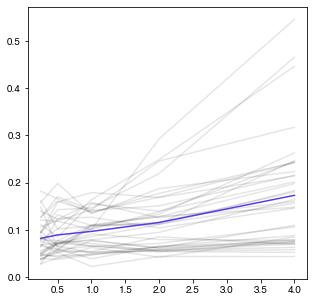

In [185]:
# FIGURE 2 A? Plot the max min and ptt responses for each unique parameter value
save_fig = False

max_fig, max_ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(max_response_list)):
    max_ax.plot(unique_parameter_values, max_response_list[i], color='k', alpha=0.1)
max_ax.plot(unique_parameter_values, mean_max_response, color=paleDarkBlue)
max_ax.fill_between(unique_parameter_values, sem_max_plus, sem_max_minus, color=paleDarkBlue, alpha=0.5)
max_ax.set_xlabel('LED Intensity')
max_ax.set_ylabel('Max Response (DF/F)')
max_ax.spines['right'].set_visible(False)
max_ax.spines['top'].set_visible(False)

min_fig, min_ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(min_response_list)):
    min_ax.plot(unique_parameter_values, min_response_list[i], color='k', alpha=0.1)
min_ax.plot(unique_parameter_values, mean_min_response, color=paleDarkBlue)
min_ax.fill_between(unique_parameter_values, sem_min_plus, sem_min_minus, color=paleDarkBlue, alpha=0.5)
min_ax.set_xlabel('LED Intensity')
min_ax.set_ylabel('Min Response (DF/F)')
min_ax.spines['right'].set_visible(False)
min_ax.spines['top'].set_visible(False)

ptt_fig, ptt_ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(len(ptt_list)):
    ptt_ax.plot(unique_parameter_values, ptt_list[i], color='k', alpha=0.1)
ptt_ax.plot(unique_parameter_values, mean_ptt, color=paleDarkBlue)
ptt_ax.fill_between(unique_parameter_values, sem_ptt_plus, sem_ptt_minus, color=paleDarkBlue, alpha=0.5)
ptt_ax.set_xlabel('LED Intensity')
ptt_ax.set_ylabel('Peak to Trough (DF/F)')
ptt_ax.spines['right'].set_visible(False)
ptt_ax.spines['top'].set_visible(False)

if save_fig == True:
    max_fig.savefig(save_directory+'2B.max_response.png', dpi=300, bbox_inches='tight')
    max_fig.savefig(save_directory+'2B.max_response.svg', dpi=300, bbox_inches='tight')
    min_fig.savefig(save_directory+'2B.min_response.png', dpi=300, bbox_inches='tight')
    min_fig.savefig(save_directory+'2B.min_response.svg', dpi=300, bbox_inches='tight')
    ptt_fig.savefig(save_directory+'2B.ptt.png', dpi=300, bbox_inches='tight')
    ptt_fig.savefig(save_directory+'2B.ptt.svg', dpi=300, bbox_inches='tight')

## Plot individual ROIs - Not a figure but a way to check

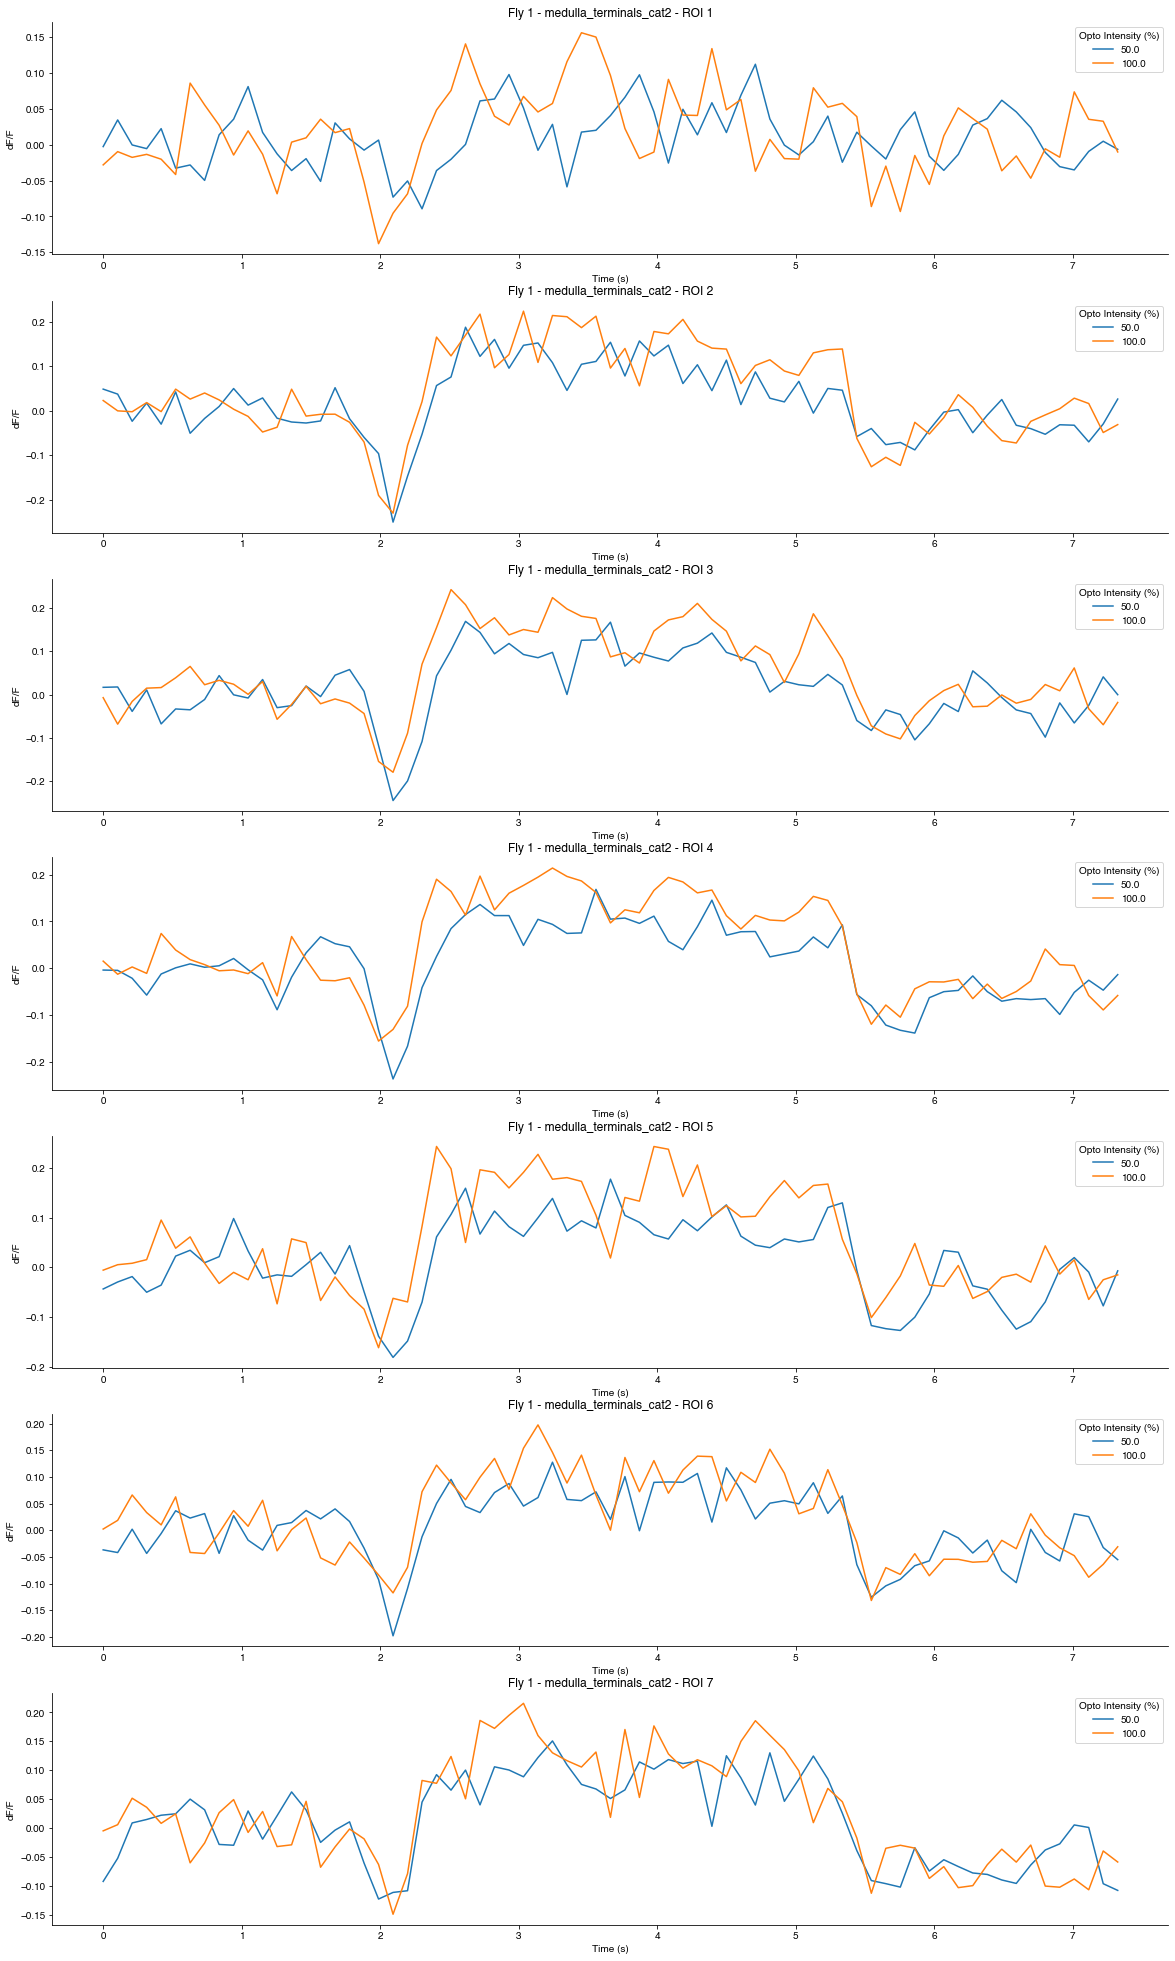

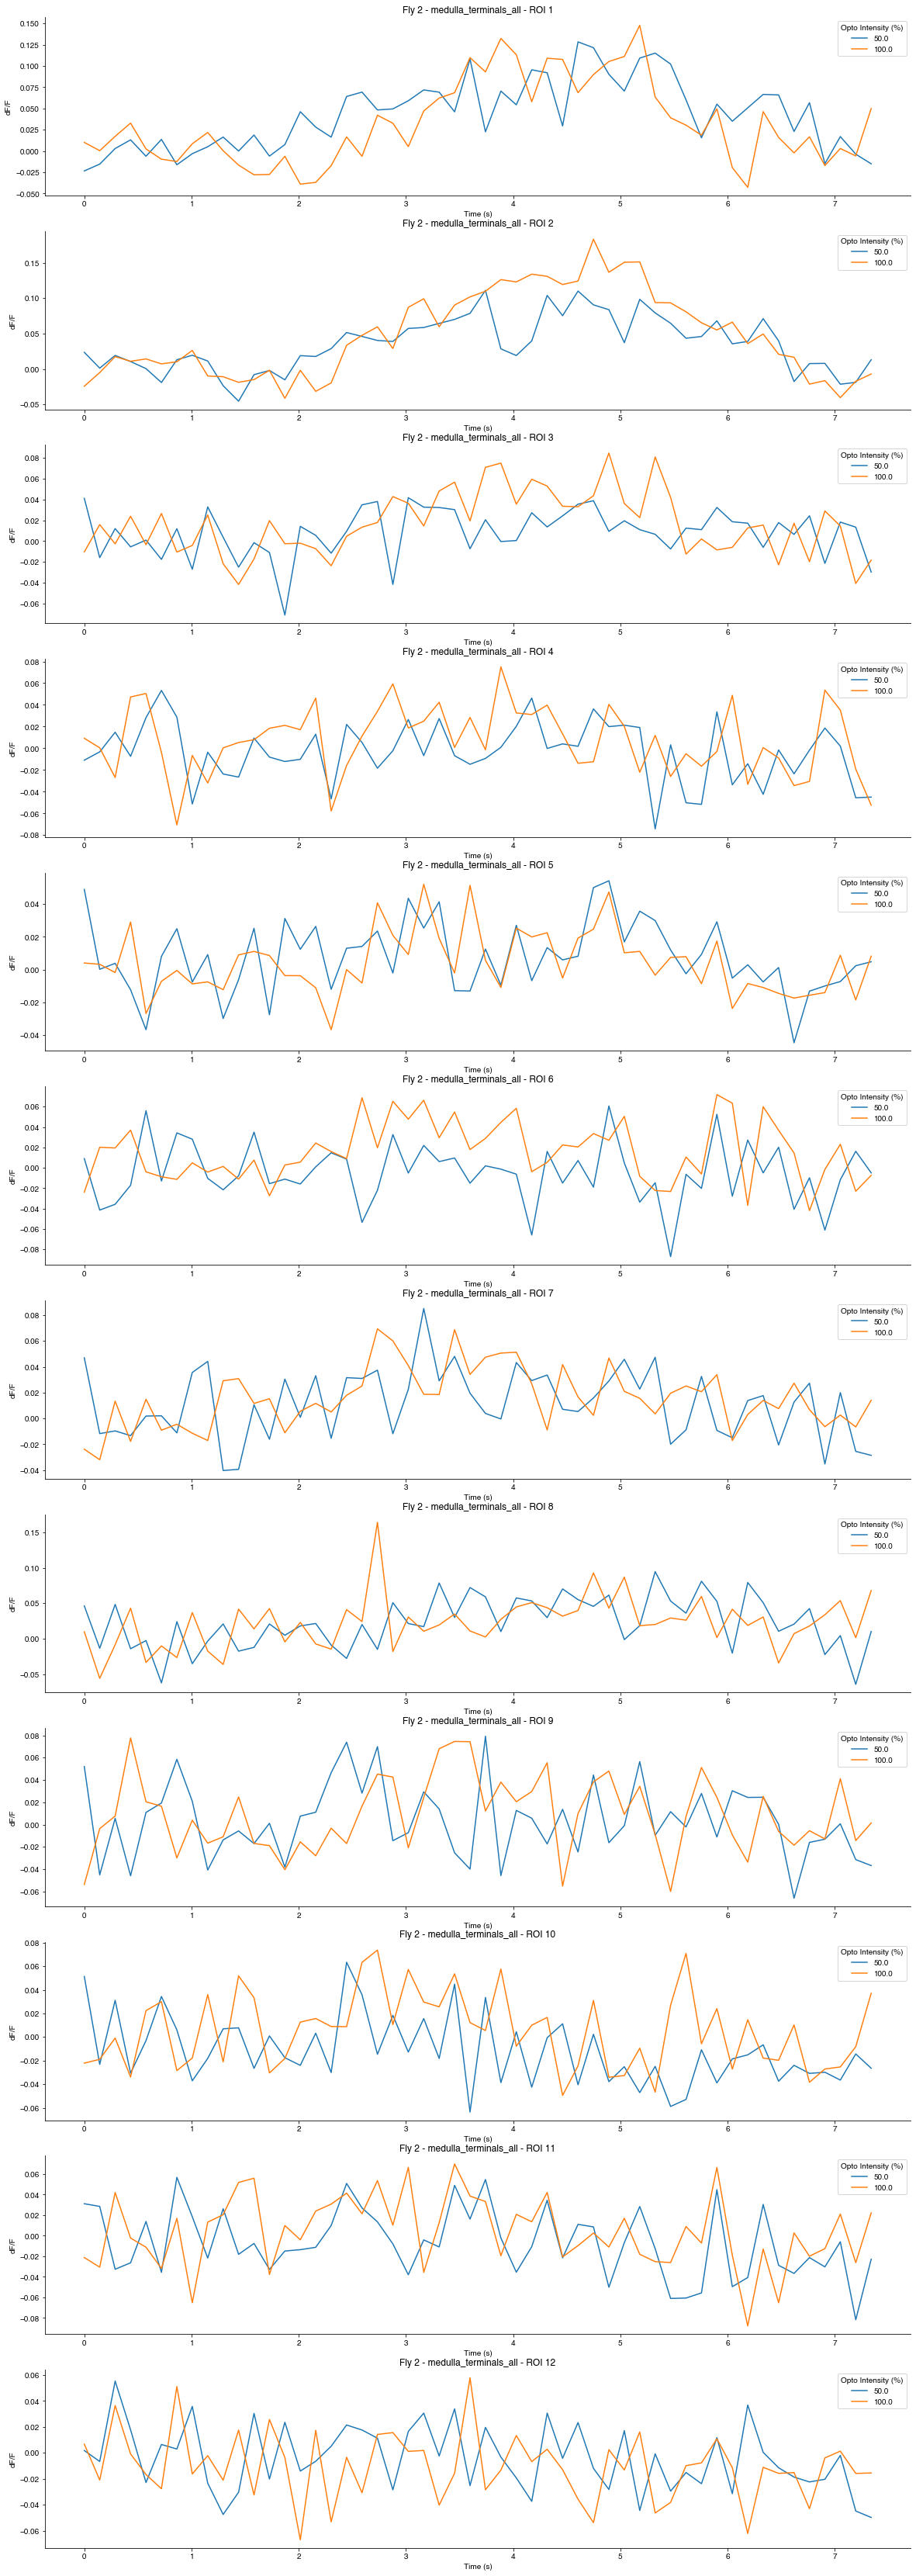

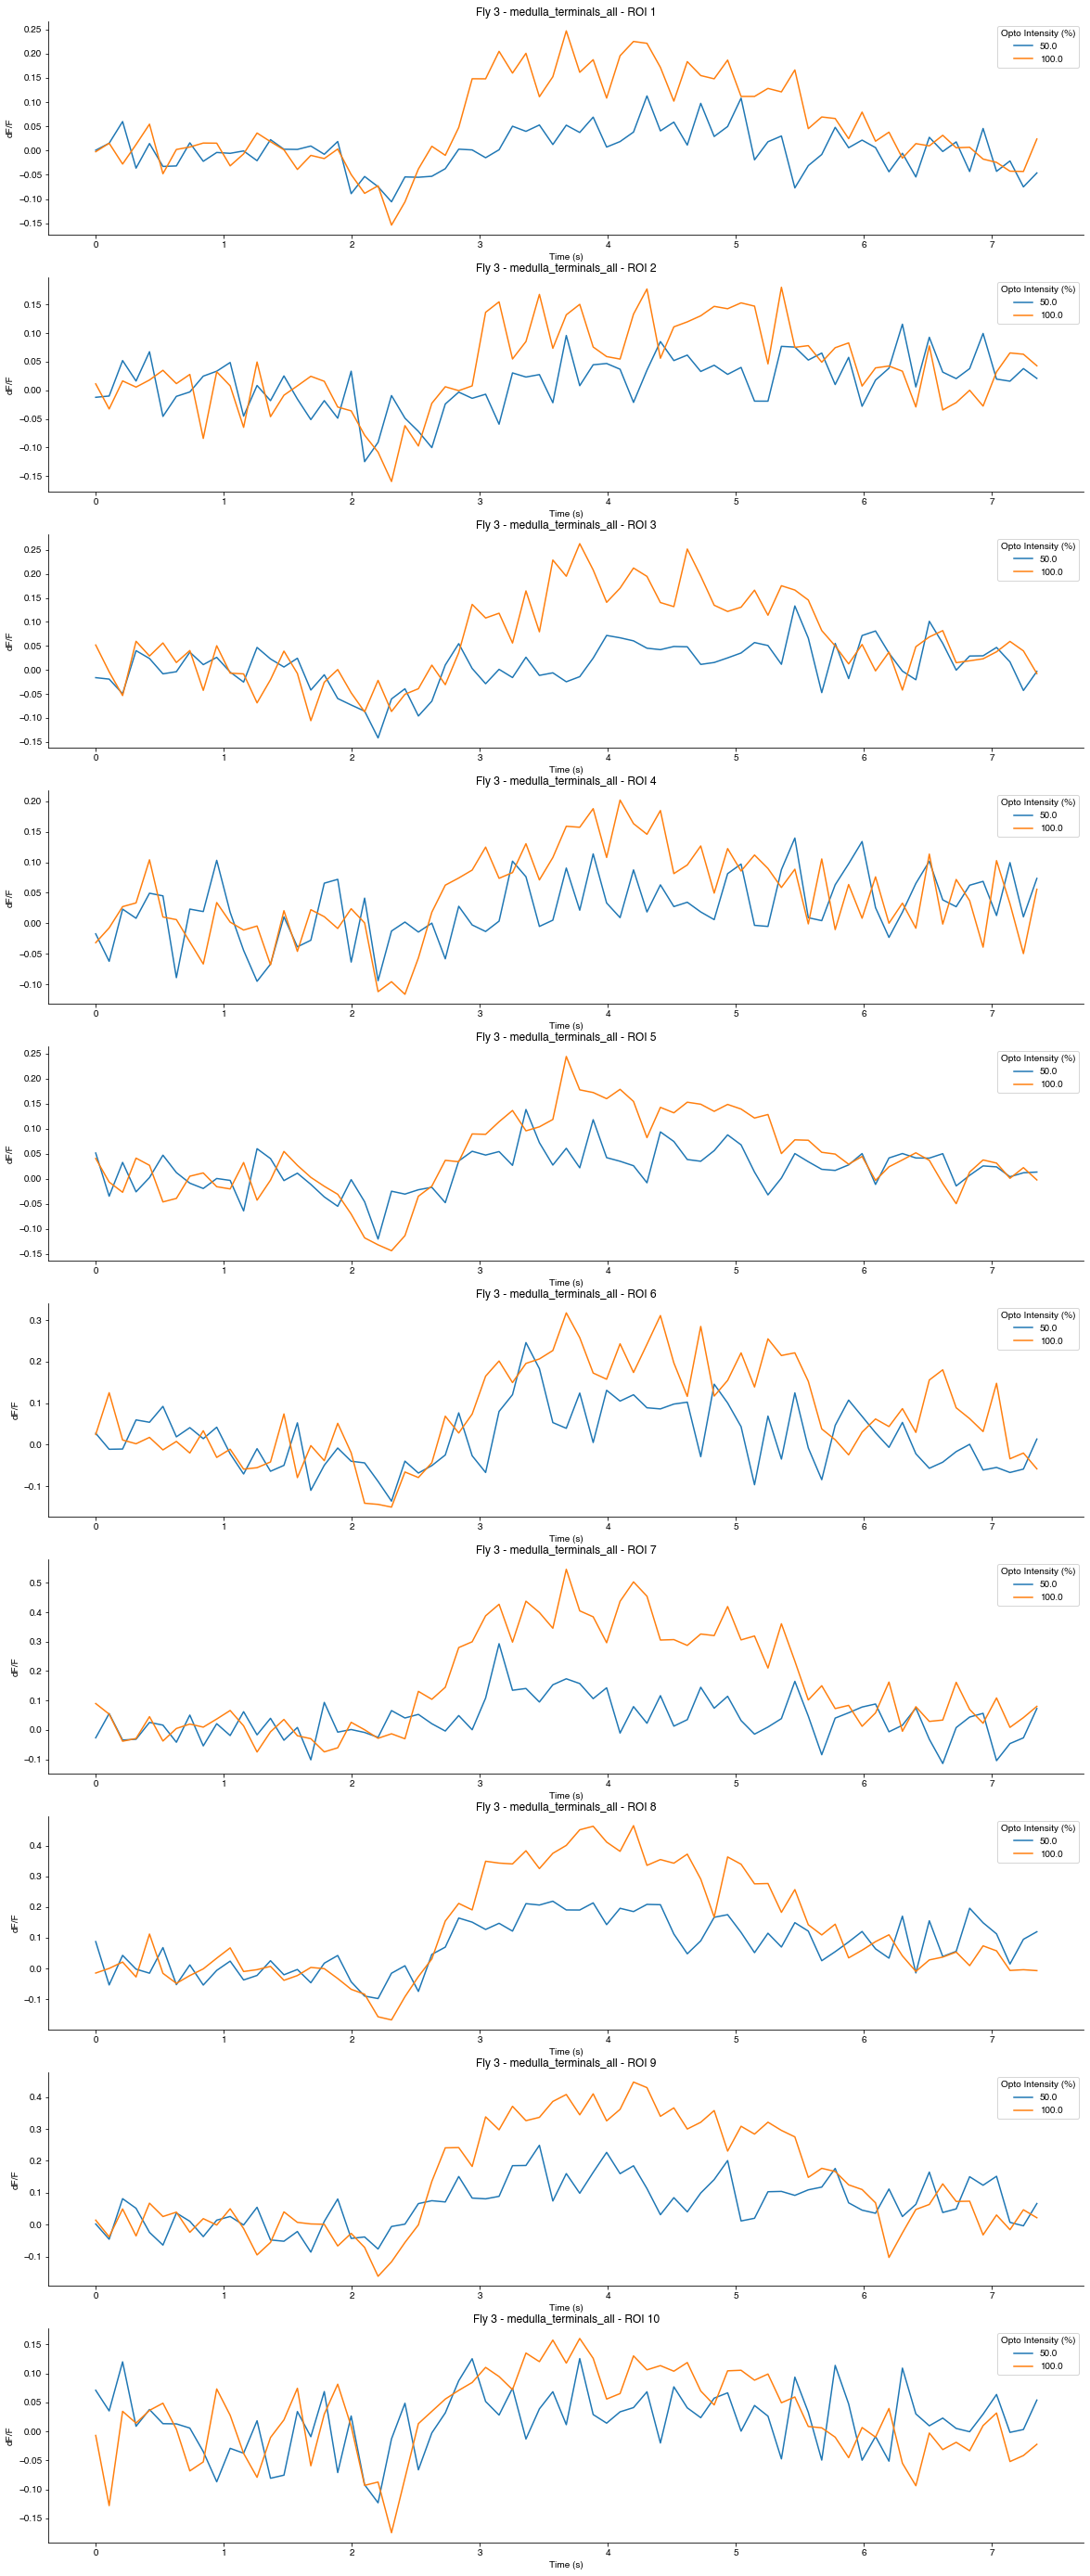

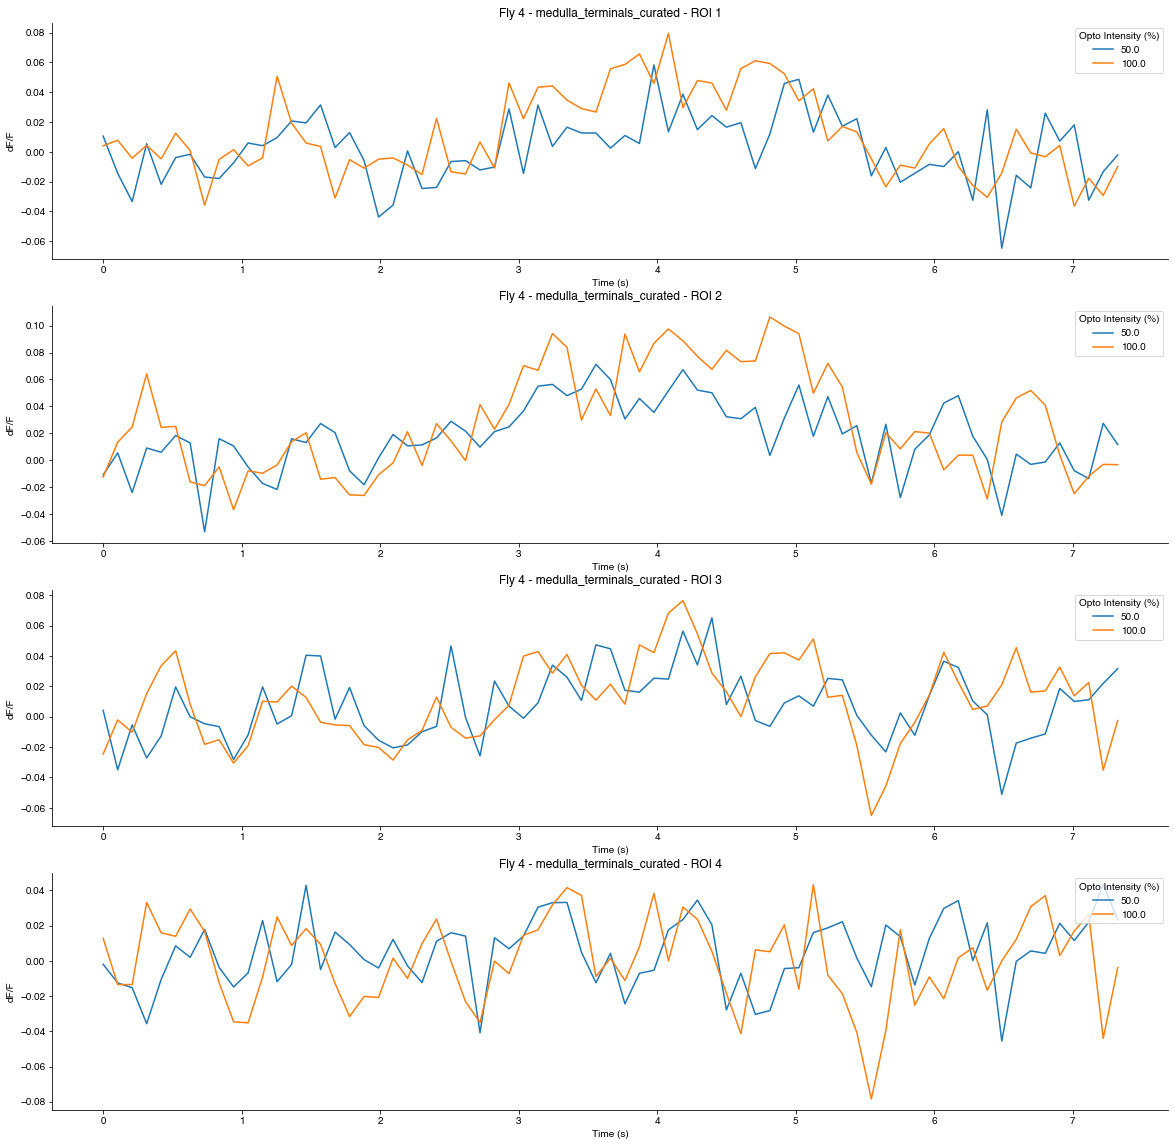

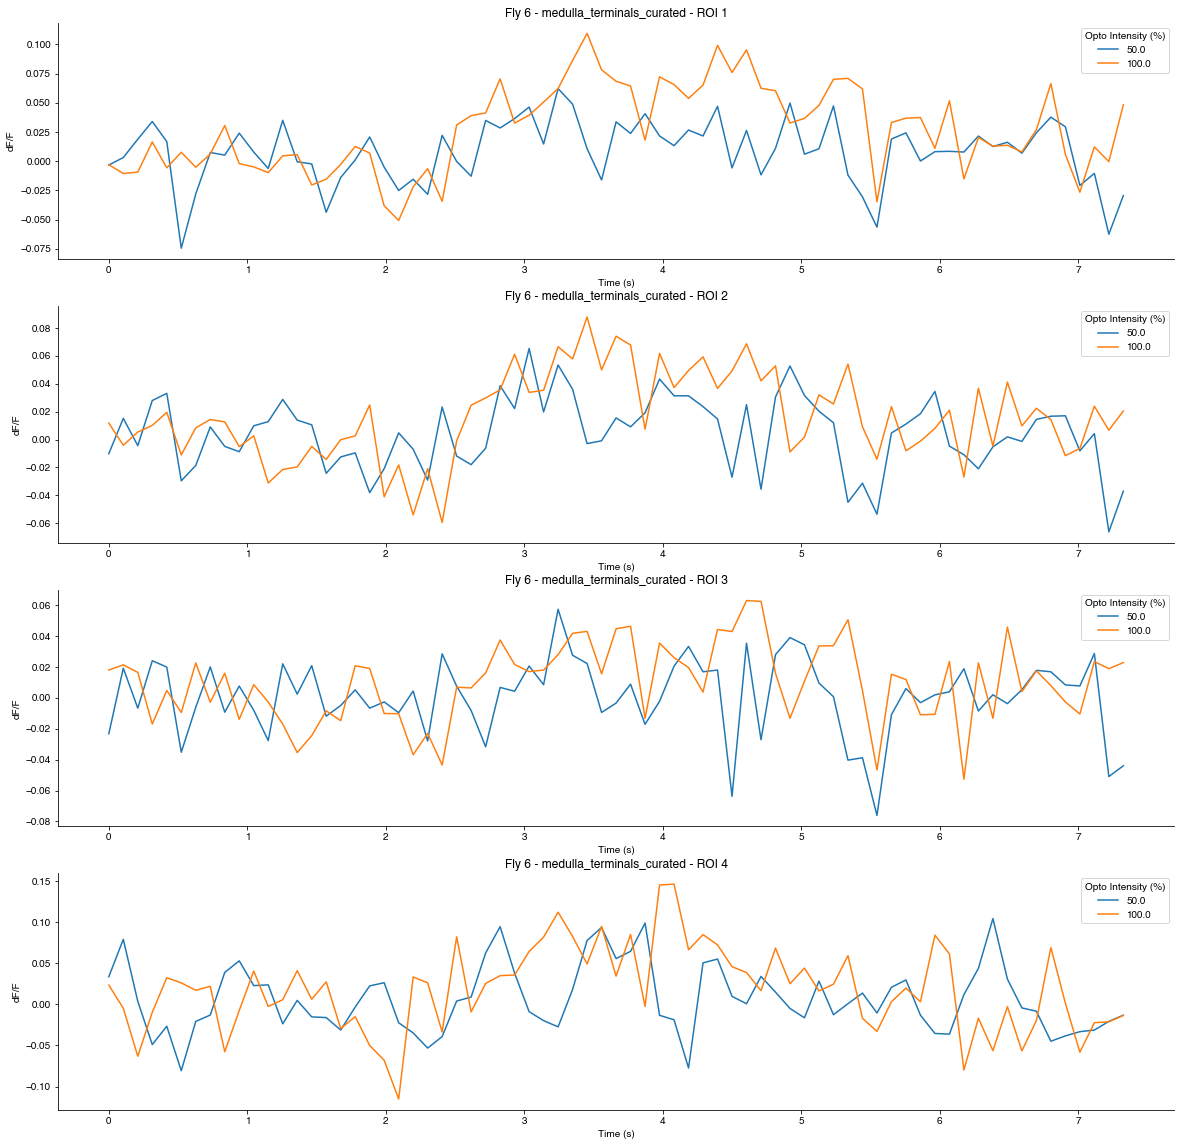

In [5]:
# Call function to get trial data for each fly
which_set = asta_prox_all
which_list = asta_fly_list_all

# interpolation parameters
num_time_points = 71
time_vector_interp = np.linspace(0, time_vector[-1], num_time_points)
cross_fly_mean_response = []

for fly_ind in range(len(which_set)):
    unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(which_set[fly_ind])
    opto_values = calculateOptoPercentages(unique_parameter_values)
    # interpolate the mean_response[-1] to 71 timepoints

    # interpolate the mean_response to have the same number of time points
    mean_response_interp = np.zeros([mean_response.shape[0], mean_response.shape[1], num_time_points])
    for intensity_ind in range(mean_response.shape[1]):
        for roi_ind in range(mean_response.shape[0]):
            mean_response_interp[roi_ind, intensity_ind, :] = np.interp(time_vector_interp, time_vector, mean_response[roi_ind, intensity_ind, :])

    if fly_ind == 0:
        cross_fly_mean_response = mean_response_interp
    else:
        cross_fly_mean_response = np.append(cross_fly_mean_response, mean_response_interp, axis=0)
    # create subplots for each ROI
    fig, ax = plt.subplots(len(mean_response), 1, figsize=(20, 5*len(mean_response)))

    for roi_ind in range(len(mean_response)):
        # for each opto intensity
        # for opto_ind in range(len(opto_values)): # all opto values
        for opto_ind in [3, 4]: # specific opto values
            # plot the mean response
            ax[roi_ind].plot(time_vector, mean_response[roi_ind][opto_ind], label=opto_values[opto_ind])
            # plot the SEM
            #ax[roi_ind].fill_between(time_vector, mean_response[roi_ind][opto_ind] - sem_response[roi_ind][opto_ind], mean_response[roi_ind][opto_ind] + sem_response[roi_ind][opto_ind], alpha=0.2)
            
        ax[roi_ind].set_title('Fly ' + str(which_list[fly_ind]) + ' - ' + str(which_set[fly_ind][3]) + ' - ROI ' + str(roi_ind+1))
        ax[roi_ind].set_xlabel('Time (s)')
        ax[roi_ind].set_ylabel('dF/F')
        ax[roi_ind].legend(title='Opto Intensity (%)', loc='upper right')
        ax[roi_ind].spines['top'].set_visible(False)
        ax[roi_ind].spines['right'].set_visible(False)

Calculate LED times

In [8]:
fly = asta_prox_all[0]
file_path = os.path.join(fly[0], fly[1] + ".hdf5")
ID = imaging_data.ImagingDataObject(file_path, fly[2], quiet=True)
# OPTO stim plotting
led_start_time = ID.getRunParameters('pre_time')
led_end_time = led_start_time + ID.getRunParameters('led_duration')[0]   

## Figure 2A - Mean Response across all ROIs, all opto intensities on same plot

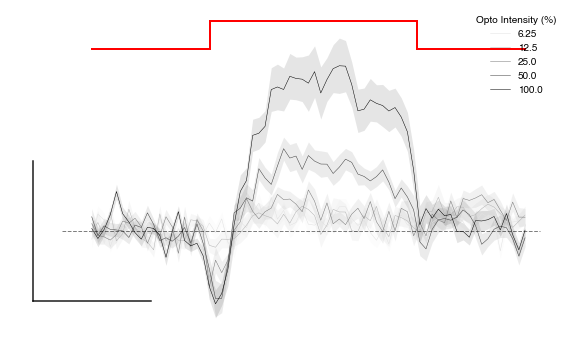

In [17]:
save_fig = True
boring_colors = True
clean_look = True

mean_response_across_rois = np.mean(cross_fly_mean_response, axis=0)
sem_response_across_rois = np.std(cross_fly_mean_response, axis=0) / np.sqrt(cross_fly_mean_response.shape[0])
sem_plus = mean_response_across_rois + sem_response_across_rois
sem_minus = mean_response_across_rois - sem_response_across_rois

cmap = plt.get_cmap('winter')
colors = [cmap(i) for i in np.linspace(0, 1, len(opto_values))]

if boring_colors:
    cmap = plt.get_cmap('Greys')
    colors = [cmap(i) for i in np.linspace(0.2, 1, len(opto_values))]

# # Plot the average response across all ROIs
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
for opto_ind in range(len(opto_values)):
    # plot the mean response
    ax.plot(time_vector_interp, np.mean(cross_fly_mean_response[:, opto_ind, :], axis=0), label=opto_values[opto_ind], color=colors[opto_ind], linewidth=0.5)
    # plot the SEM
    ax.fill_between(time_vector_interp, sem_plus[opto_ind], sem_minus[opto_ind], alpha=0.1, color=colors[opto_ind], linewidth=0)
# Plot opto stim at led_start_time to led_end_time as a step function
ax.plot([0, led_start_time], [0.13, 0.13], color='red', linewidth=2)
ax.plot([led_start_time, led_start_time], [0.13, 0.15], color='red', linewidth=2)
ax.plot([led_start_time, led_end_time], [0.15, 0.15], color='red', linewidth=2)
ax.plot([led_end_time, led_end_time], [0.13, 0.15], color='red', linewidth=2)
ax.plot([led_end_time, time_vector_interp[-1]], [0.13, 0.13], color='red', linewidth=2)

#ax.axvspan(led_start_time, led_end_time, alpha=0.1, color='yellow')
# plot a line from x=0 to x=time_vector_interp[-1] at y=0

if clean_look:
    plot_tools.cleanAxes(ax)
    plot_tools.addScaleBars(ax, dT=2, dF=0.1, T_value=-1, F_value=-0.05)
    ax.plot([-0.5, time_vector_interp[-1]+0.25], [0, 0], color='black', linewidth=1, linestyle='--', alpha=0.5)

else:
    #plot_tools.cleanAxes(ax)
    ax.set_title('Mean Response Across All ROIs')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('dF/F')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0, time_vector_interp[-1]], [0, 0], color='black', linewidth=1, linestyle='--', alpha=0.5)

ax.legend(title='Opto Intensity (%)', loc='upper right', frameon=False)



if save_fig == True:
    fig.savefig(save_directory+f'2A.mean_response.{clean_look}.boring-{boring_colors}_2.png', dpi=300, bbox_inches='tight')
    fig.savefig(save_directory+f'2A.mean_response.{clean_look}.boring-{boring_colors}_2.svg', dpi=300, bbox_inches='tight')



## Figure 2A - Mean Response across all ROIs, all opto intensities on different subplots

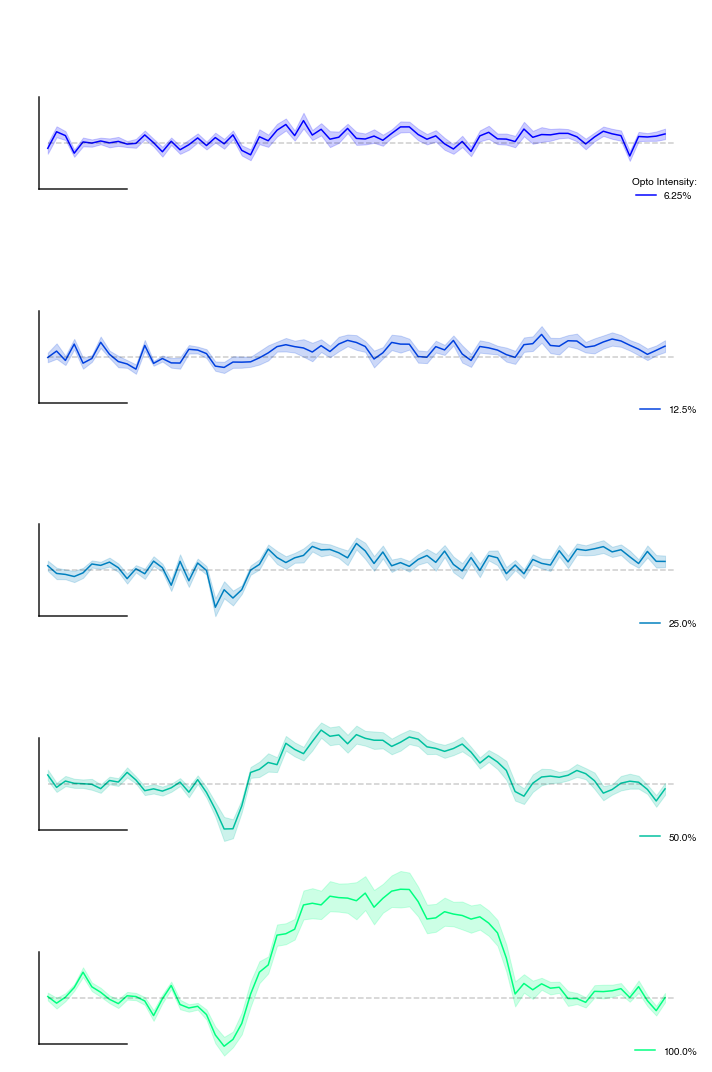

In [129]:
# plot each opto intensity as a separate subplot
cmap = plt.get_cmap('winter')
colors = [cmap(i) for i in np.linspace(0, 1, len(opto_values))]

fig, ax = plt.subplots(len(opto_values), 1, figsize=(10, 3*len(opto_values)), sharex=True, sharey=True)
for opto_ind in range(len(opto_values)):
    ax[opto_ind].plot(np.mean(cross_fly_mean_response[:, opto_ind, :], axis=0), label=f'{str(opto_values[opto_ind])}%', color=colors[opto_ind])
    ax[opto_ind].fill_between(np.arange(0, num_time_points), sem_plus[opto_ind], sem_minus[opto_ind], alpha=0.2, color=colors[opto_ind])

    ax[opto_ind].plot([0, num_time_points], [0, 0], color='black', linestyle='--', alpha=0.2)

    ax[opto_ind].set_ylabel('dF/F')
    ax[opto_ind].spines['top'].set_visible(False)
    ax[opto_ind].spines['right'].set_visible(False)
    plot_tools.cleanAxes(ax[opto_ind])
    plot_tools.addScaleBars(ax[opto_ind], dT=10, dF=0.1, T_value=-1, F_value=-0.05)

    if opto_ind == 0:
        ax[opto_ind].legend(title='Opto Intensity:', loc='lower right', frameon=False)
    else:
        ax[opto_ind].legend(loc='lower right', frameon=False)

    # if opto_ind != len(opto_values)-1:
    #     ax[opto_ind].spines['bottom'].set_visible(False)
    #     ax[opto_ind].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# make the figure layout tight
plt.tight_layout()

if save_fig == True:
    fig.savefig(save_directory+'2A.mean_response_subplots.png', dpi=300, bbox_inches='tight')
    fig.savefig(save_directory+'2A.mean_response_subplots.svg', dpi=300, bbox_inches='tight')

## Plot Average across ROIs, by fly, for each opto intensity

In [126]:
# Take in experiments and output ROI-averaged responses to flash across opto intensities
def acrossROIsPlotter(which_set, which_list, which_opto, save_fig=False):
    cmap = plt.get_cmap('Accent') # also 'cool' 'winter' 'PRGn' 'Pastel1' 'YlGnBu' 'twilight'
    fig, ax = plt.subplots(len(which_set), 1, figsize=(20, 5*len(which_set)))

    # for each fly, plot the average of the ROIs for each opto intensity
    for fly_ind in range(len(which_set)):
        unique_parameter_values, mean_response, sem_response, trial_response_by_stimulus_intensity, time_vector = getTrialData(which_set[fly_ind])
        opto_values = calculateOptoPercentages(unique_parameter_values)
        colors = [cmap(i) for i in np.linspace(0.1, 1.0, len(opto_values))]
        
        # calculate sem
        sem = np.std(mean_response, axis=0)/np.sqrt(len(mean_response))
        sem_plus = np.mean(mean_response, axis=0) + sem
        sem_minus = np.mean(mean_response, axis=0) - sem
        print(f'sem.shape: {sem.shape}')

        # for each opto intensity
        # for opto_ind in range(len(opto_values)): # all the opto intensities
        for opto_ind in which_opto: # specific opto intensities
            # plot the mean response
            ax[fly_ind].plot(time_vector, np.mean(mean_response, axis=0)[opto_ind], 
                            label=opto_values[opto_ind], color=colors[opto_ind],)
            ax[fly_ind].fill_between(time_vector, sem_minus[opto_ind], sem_plus[opto_ind], 
                                    alpha=0.2, color=colors[opto_ind])
            
        # OPTO stim plotting
        # find the minimum and maximum values of the mean response
        y_low = np.min(sem_minus)*1.1
        y_high = np.max(sem_plus)*1.1
        ax[fly_ind].fill_between([led_start_time, led_end_time], y_low, y_high, 
                        alpha=0.05, edgecolor='r', facecolor='r', linewidth=3,)
            
        ax[fly_ind].set_title('Fly ' + str(which_list[fly_ind]) + ' - ' + str(which_set[fly_ind][3]) + ' - Average of ROIs')
        ax[fly_ind].set_xlabel('Time (s)')
        ax[fly_ind].set_ylabel('dF/F')
        ax[fly_ind].legend(title='Opto Intensity (%)', loc='upper right')
        ax[fly_ind].spines['top'].set_visible(False)
        ax[fly_ind].spines['right'].set_visible(False)

        if save_fig:
            fig.savefig(os.path.join(save_directory, 'acrossROIsPlotter.png'), bbox_inches='tight', dpi=300)

All the flies
sem.shape: (5, 71)
sem.shape: (5, 52)
sem.shape: (5, 71)
sem.shape: (5, 71)
sem.shape: (5, 71)
sem.shape: (5, 71)


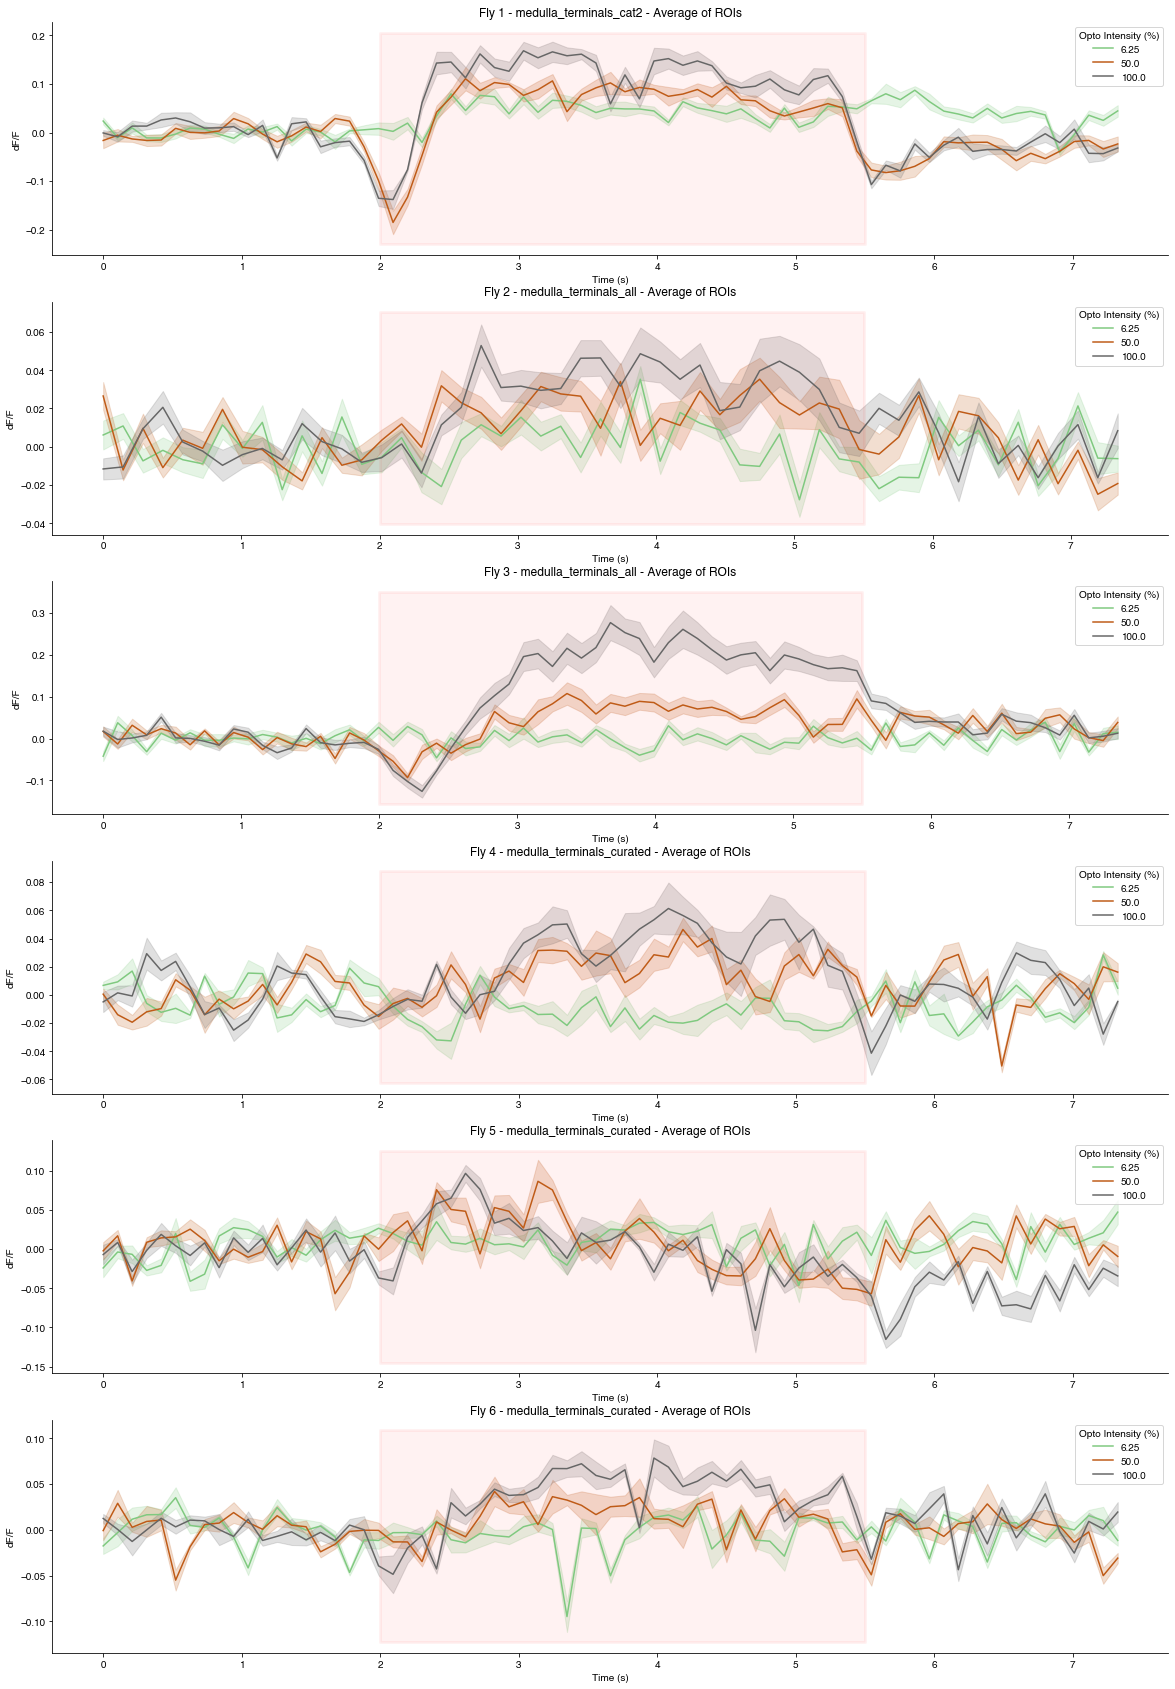

In [127]:
# Call the acrossROIsPlotter function
print('All the flies')
acrossROIsPlotter(asta_prox_all, asta_fly_list_all, [0, 3, 4], save_fig=True)

# print('Only the 5.24 flies with IR OFF')
# acrossROIsPlotter(asta_prox_5_24, asta_fly_list_5_24, [3, 4])

# print('Only the 5.24 flies with IR ON')
# acrossROIsPlotter(asta_prox_5_24_IR_ON, asta_fly_list_5_24_IR_ON, [3, 4])

## Testing the effect of IR illumination of fly during opto

In [123]:
# make a function to plot the IR OFF and IR ON flies on the same plot

# import gaussian_filter1
from scipy.ndimage import gaussian_filter1d

def acrossROIsPlotterIR(IR_OFF_set, IR_ON_set, which_list, which_opto, error_bars=False, save_fig=False):
    cmap = plt.get_cmap('spring') # also 'cool' 'winter' 'PRGn' 'Pastel1' 'YlGnBu' 'twilight'
    cmap1 = plt.get_cmap('winter')
    fig, ax = plt.subplots(len(IR_OFF_set), 1, figsize=(20, 6*len(IR_OFF_set)))

    # for each fly, plot the average of the ROIs for each opto intensity
    for fly_ind in range(len(IR_OFF_set)):
        unique_parameter_values_OFF, mean_response_OFF, _, _, time_vector = getTrialData(IR_OFF_set[fly_ind])
        _, mean_response_ON, _, _, _ = getTrialData(IR_ON_set[fly_ind])
        opto_values = calculateOptoPercentages(unique_parameter_values_OFF)
        colors = [cmap(i) for i in np.linspace(0, 0.9, len(which_opto))]
        colors1 = [cmap1(i) for i in np.linspace(0, 0.9, len(which_opto))]
        
        # calculate sem
        sem_OFF = np.std(mean_response_OFF, axis=0)/np.sqrt(len(mean_response_OFF))
        sem_plus_OFF = np.mean(mean_response_OFF, axis=0) + sem_OFF
        sem_minus_OFF = np.mean(mean_response_OFF, axis=0) - sem_OFF
        sem_ON = np.std(mean_response_ON, axis=0)/np.sqrt(len(mean_response_ON))
        sem_plus_ON = np.mean(mean_response_ON, axis=0) + sem_ON
        sem_minus_ON = np.mean(mean_response_ON, axis=0) - sem_ON
        
        # for each opto intensity
        for opto_ind, opto in enumerate(which_opto): # specific opto intensities
            # plot the mean response
            # apply a gaussian filter to the mean responses
            mean_response_OFF_gauss = gaussian_filter1d(np.mean(mean_response_OFF, axis=0)[opto], sigma=2)
            mean_response_ON_gauss = gaussian_filter1d(np.mean(mean_response_ON, axis=0)[opto], sigma=2)

            # plot the gaussian filtered data
            ax[fly_ind].plot(time_vector, mean_response_OFF_gauss,
                            label=(f'{opto_values[opto]} - IR OFF'), color=colors[opto_ind])
            ax[fly_ind].plot(time_vector, mean_response_ON_gauss,
                            label=(f'{opto_values[opto]} - IR ON'), color=colors1[opto_ind])
            
            if error_bars: #error bars can be distracting
                ax[fly_ind].fill_between(time_vector, sem_minus_OFF[opto], sem_plus_OFF[opto],
                                    alpha=0.2, color=colors[opto_ind])
                ax[fly_ind].fill_between(time_vector, sem_minus_ON[opto], sem_plus_ON[opto],
                                    alpha=0.2, color=colors1[opto_ind])
                y_low = np.min([np.min(sem_minus_OFF), np.min(sem_minus_ON)])*1.1
                y_high = np.max([np.max(sem_plus_OFF), np.max(sem_plus_ON)])*1.1

            else:
                y_low = np.min([np.min(mean_response_OFF_gauss), np.min(mean_response_ON_gauss)])*1.1
                y_high = np.max([np.max(mean_response_OFF_gauss), np.max(mean_response_ON_gauss)])*1.1
            
        # OPTO stim plotting
        ax[fly_ind].fill_between([led_start_time, led_end_time], y_low, y_high, alpha=0.05, edgecolor='r', facecolor='r', linewidth=3,)

        ax[fly_ind].set_title('Fly ' + str(which_list[fly_ind]) + ' - ' + str(IR_OFF_set[fly_ind][3]) + ' - Average of ROIs')
        ax[fly_ind].set_xlabel('Time (s)')
        ax[fly_ind].set_ylabel('dF/F')
        ax[fly_ind].legend(title='Opto Intensity (%)', loc='upper right')
        ax[fly_ind].spines['top'].set_visible(False)
        ax[fly_ind].spines['right'].set_visible(False)

    if save_fig:
        fig.savefig(
            save_directory
            + (f"acrossROIsPlotterIR.Opto{str(which_opto)}.png"),
            dpi=300, bbox_inches='tight', transparent=True,
            )

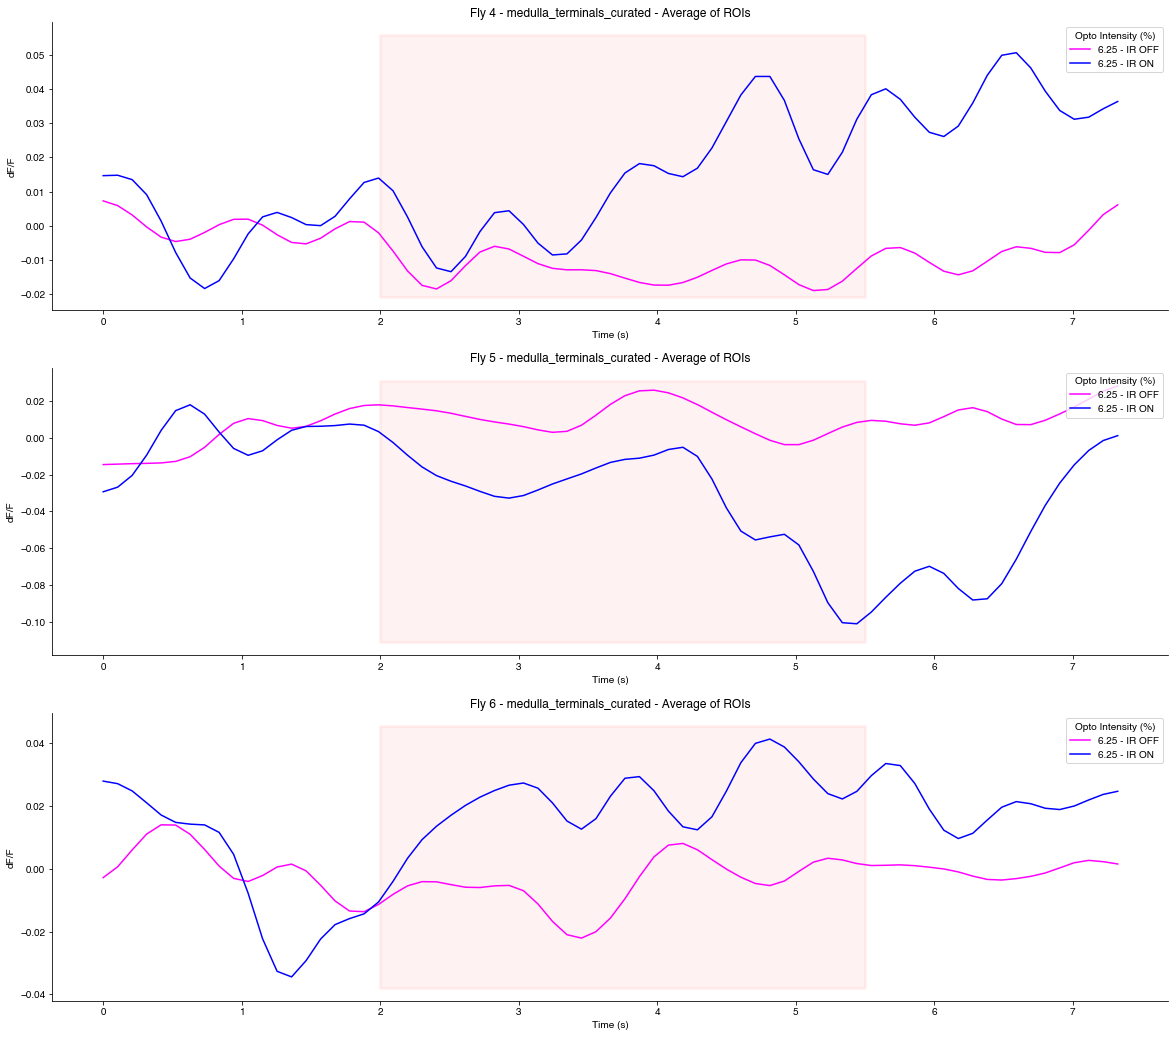

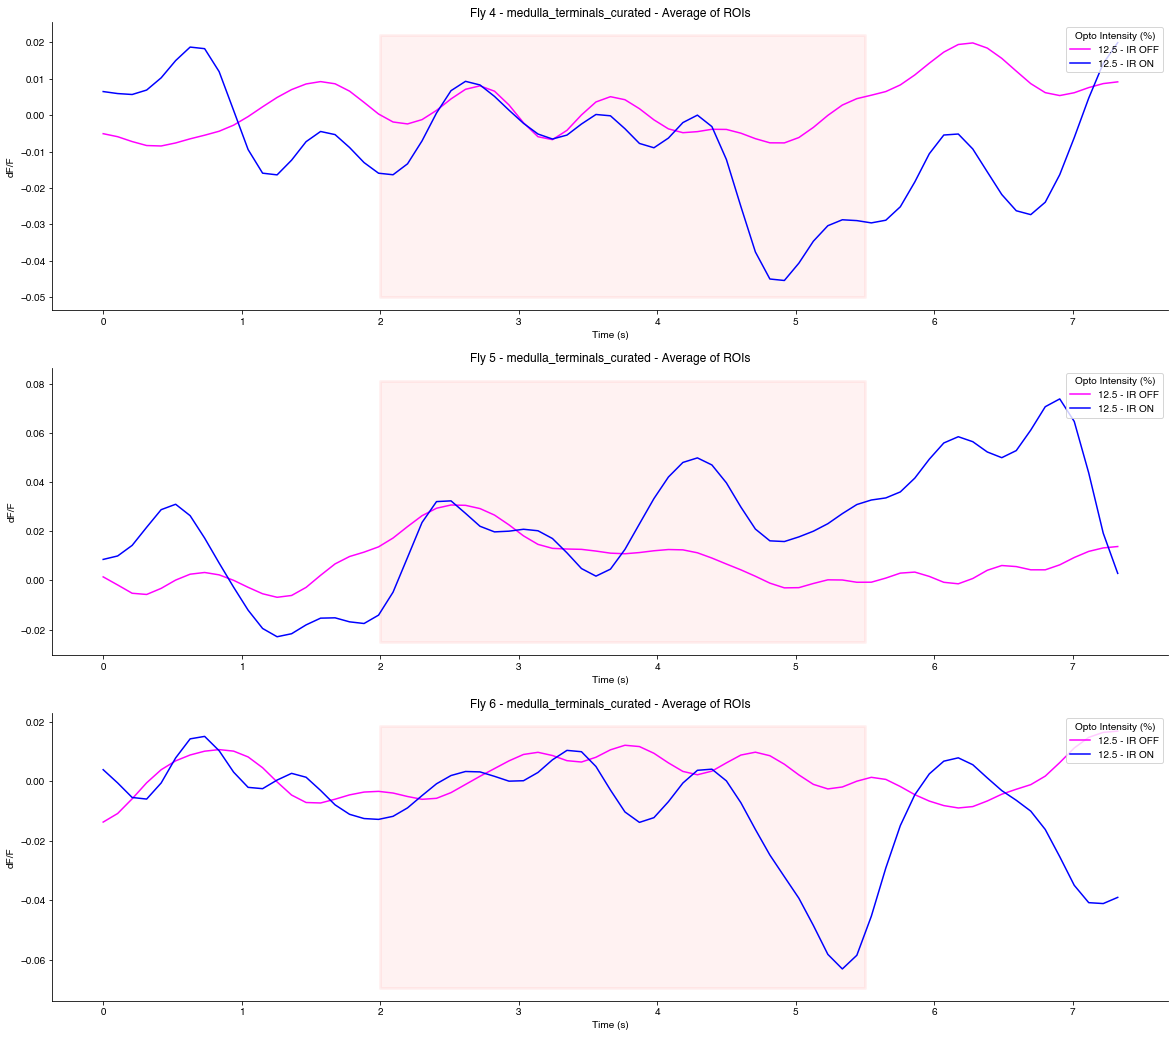

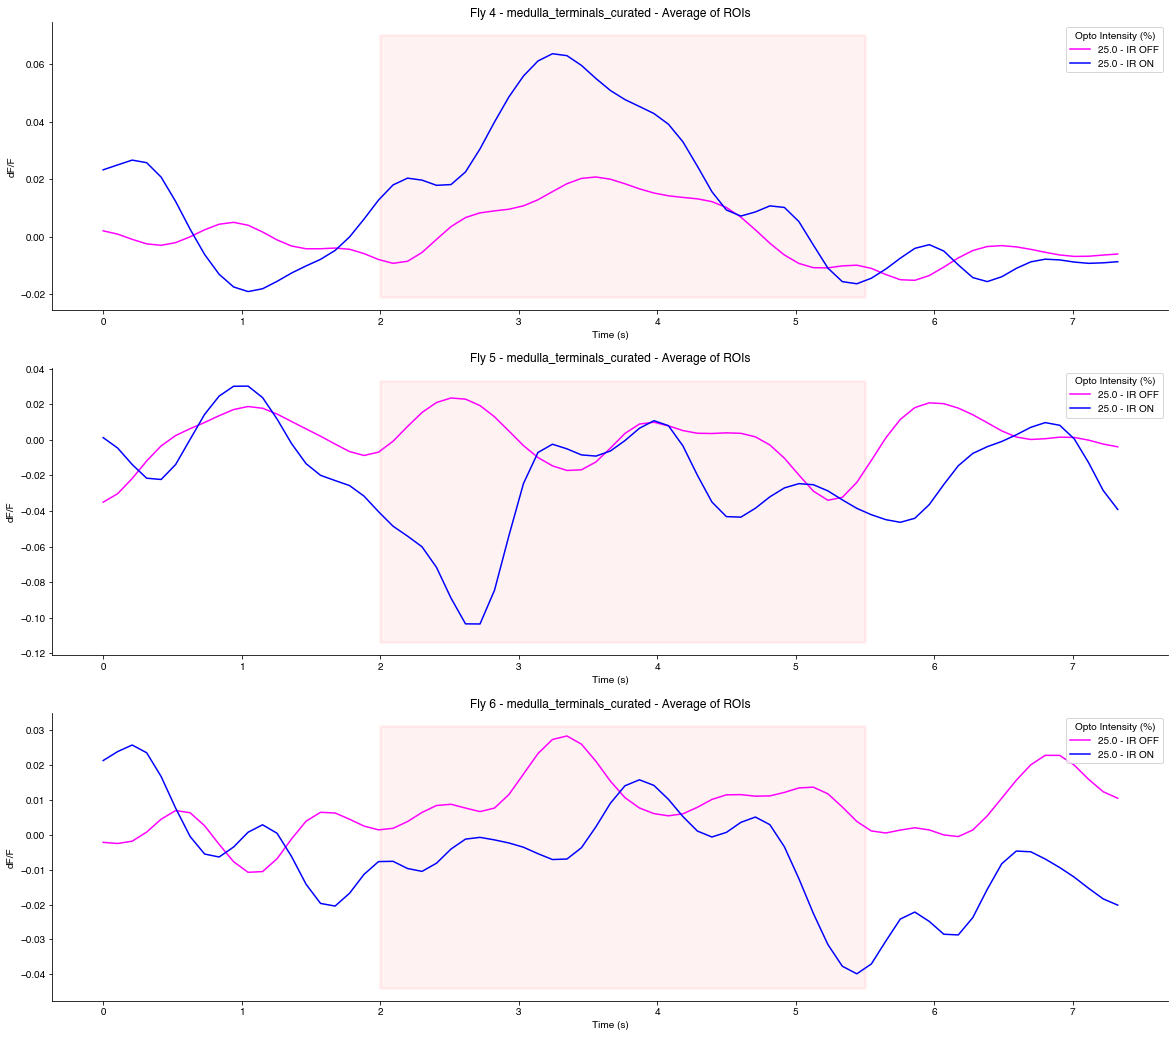

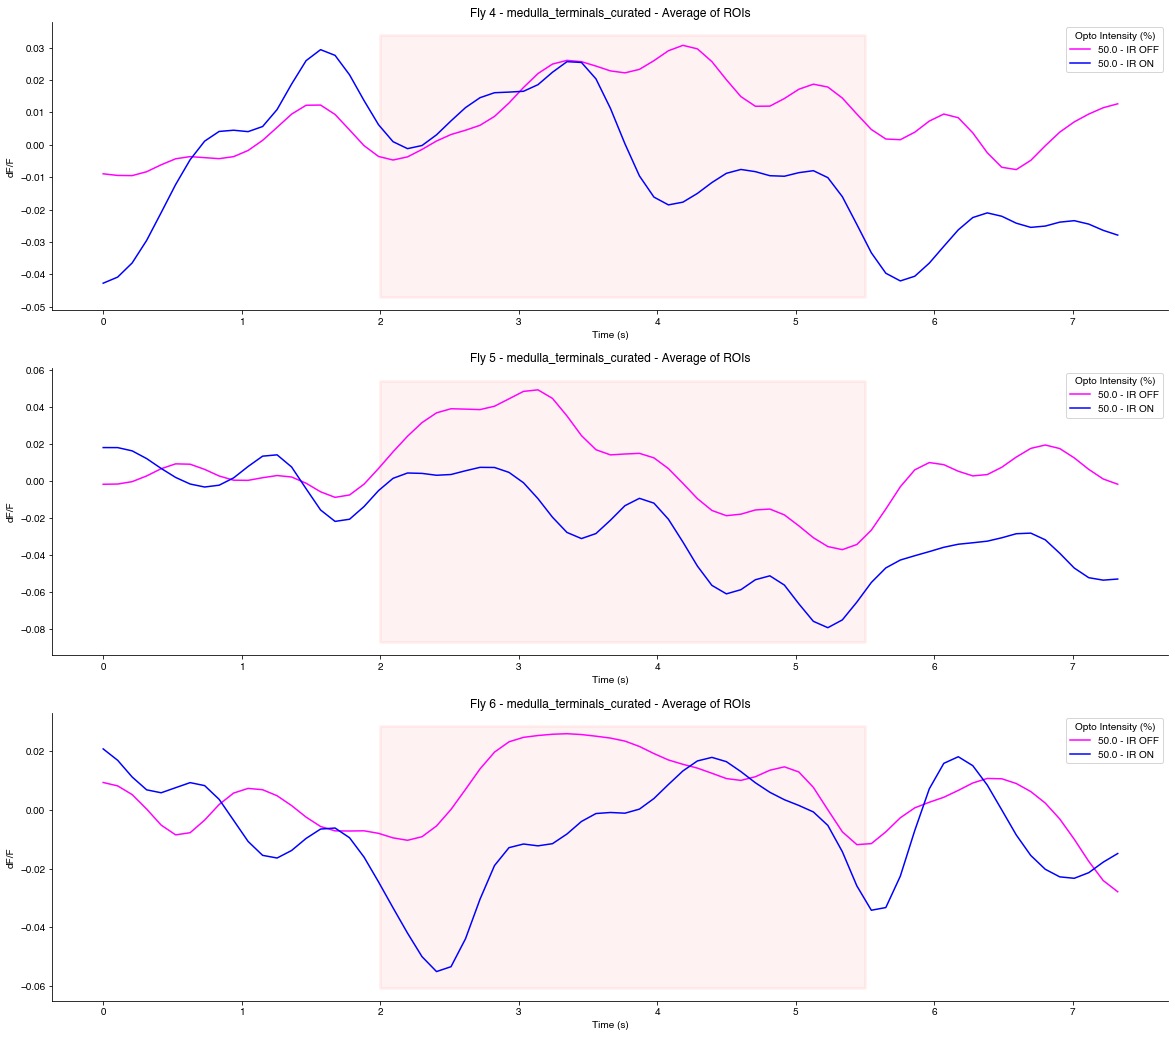

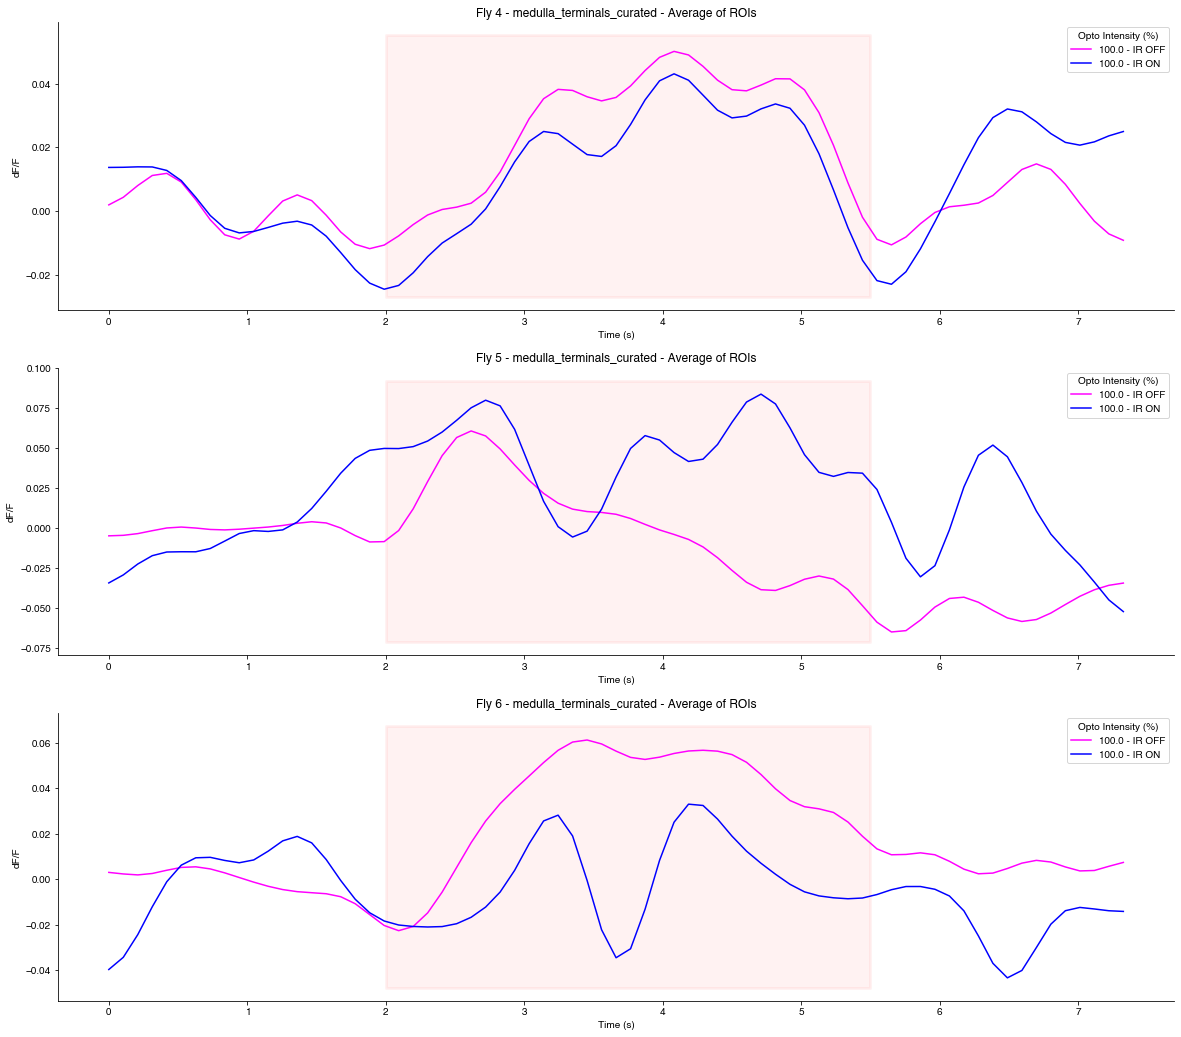

In [122]:
acrossROIsPlotterIR(asta_prox_5_24, asta_prox_5_24_IR_ON, asta_fly_list_5_24, [0], save_fig=True)
acrossROIsPlotterIR(asta_prox_5_24, asta_prox_5_24_IR_ON, asta_fly_list_5_24, [1], save_fig=True)
acrossROIsPlotterIR(asta_prox_5_24, asta_prox_5_24_IR_ON, asta_fly_list_5_24, [2], save_fig=True)
acrossROIsPlotterIR(asta_prox_5_24, asta_prox_5_24_IR_ON, asta_fly_list_5_24, [3], save_fig=True)
acrossROIsPlotterIR(asta_prox_5_24, asta_prox_5_24_IR_ON, asta_fly_list_5_24, [4], save_fig=True)